In [1]:
import numpy as np
import sympy as sm
import scipy as sp
from scipy import interpolate
from IPython.display import display
import math
import itertools
import time

import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter
%matplotlib inline

sm.init_printing(use_unicode=True)

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & \begin{cases}
w h_2 & 
\text{if }l_2 = 1  \\
b & \text{if }l_2 = 0 
\end{cases} \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_{1}& = & \begin{cases}
w h_1 & 
\text{if }l_1 = 1  \\
b & \text{if }l_1 = 0 
\end{cases} \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

**Answer to Question 1:**

In [4]:
# The basic functions are:

def utility(c, rho):
    return c**(1-rho)/(1-rho)

def consumption(w, h, l, b):
    if l == 1:
        return w*h*l
    else:
        return b

def disutility(l, gamma):
    return gamma*l

def v2(w, h2, l2, b, rho, gamma):
    return utility(consumption(w, h2, l2, b), rho) - disutility(l2, gamma)

def v1(h1, l1, v2_interp, Delta, w, b, rho, gamma, beta):
        
    # v2 value, if l1 = 0
    N_h2 = h1 + l1 + 0
    N_v2 = v2_interp([N_h2])[0]
    
    # b. v2 value, if l1 = 1
    Y_h2 = h1 + l1 + Delta
    Y_v2 = v2_interp([Y_h2])[0]
    
    # Expected v2 value
    v2 = 0.5*N_v2 + 0.5*Y_v2
    
    # Total value
    return utility(c(w,h1,l1,b),rho) - disutility(l1, gamma) + beta*v2

**Note:** the consumer in period 2, decides whether to work or not by comparing her two utilities. If she is better by not working, then decides not to work $(l_{2}=0)$, otherwise chooses to work $(l_{2}=1)$.

In [5]:
# The solution function for period 2 is:

def solve_period_2(rho, gamma, Delta):
    
    # Create the vectors for period 2
    l2_vec = np.empty(100)
    v2_vec = np.empty(100)
    
    # Solve for each h2 in grid
    for i, h2 in enumerate(h_vec):
        
        # Choose either l2 = 0 or l2 = 1
        if v2(w, h2, 1, b, rho, gamma) < v2(w, h2, 0, b, rho, gamma):
            l2_vec[i] = 0
        else:
            l2_vec[i] = 1
        
        # Save the estimated values of v2, based on the choice of working or not 
        v2_vec[i] = v2(w, h2, l2_vec[i], b, rho, gamma)
        
    return l2_vec, v2_vec

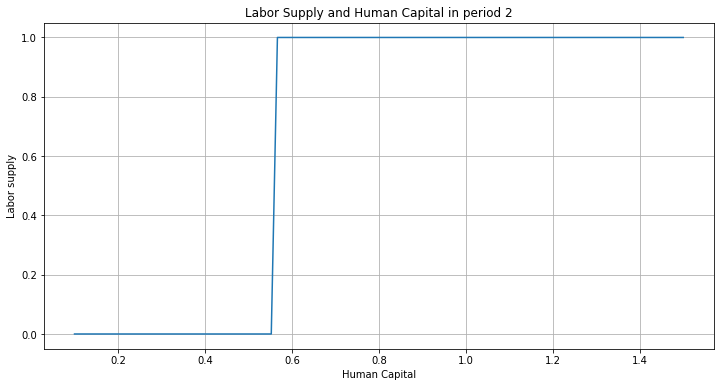

In [6]:
# Solve for period 2
l2_vec, v2_vec = solve_period_2(rho,gamma,Delta)

# Figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,l2_vec)

# Labels
ax.set_xlabel('Human Capital')
ax.set_ylabel('Labor supply')
ax.set_title('Labor Supply and Human Capital in period 2')
ax.grid()

**Conclusion:** from the above figure, we can see that the individual will choose not to work in period 2 whenever the accumulated human capital ($h_2{}$) is approximately below 0.6. If the accumulated human capital is above that level, she will get more utility by working in period 2, rather than not working.

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital).

**Answer to question 2**

In [7]:
# The solution function for period 1 is:

def solve_period_1(rho,gamma,beta,Delta,v1,v2_interp):
    
    # Create the vectors for period 1
    l1_vec = np.empty(100)
    v1_vec = np.empty(100)
    
    # Solve for each h1 in grid
    for i,h1 in enumerate(h_vec):
        
        # Choose either l1 = 0 or l1 = 1
        if v1(h1, 1, v2_interp, Delta, w, b, rho, gamma, beta) < v1(h1, 0, v2_interp, Delta, w, b, rho, gamma, beta):
            l1_vec[i] = 0
        else:
            l1_vec[i] = 1
        
        # Savie the estimated values of v1, based on the choice of working or not 
        v1_vec[i] = v1(h1, l1_vec[i], v2_interp, Delta, w, b, rho, gamma, beta)
        
    return l1_vec, v1_vec

# Construct the interpolator
v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec, bounds_error=False, fill_value=None)

In [9]:
# Solve for period 1
l1_vec,v1_vec = solve_period_1(rho, gamma, beta, Delta, v1, v2_interp)

# Figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,l1_vec)

# Labels
#font = {'family':'serif','color':'black','weight':'normal','size': 16,}
ax.set_xlabel('Human Capital')
ax.set_ylabel('Labor supply')
ax.set_title('Labor supply and human capital in period 1')#, fontdict=font)
ax.grid()

NameError: name 'c' is not defined

**Conclusion:**

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

**Answer to Question 3:**

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [ ]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Answer to question 1:**

In [ ]:
# Activating pretty printing
sm.init_printing(use_unicode=True)

In [ ]:
#Defining all the needed variables for the symbolic solution

v = sm.symbols('v_t')
y_t = sm.symbols('y_t')  
pi_t = sm.symbols('pi_t') 
h = sm.symbols('h')
alpha = sm.symbols('alpha')
b = sm.symbols('b')

pi_t_1 = sm.symbols('\pi_{t-1}')
y_t_1 = sm.symbols('y_{t-1}')
s_t = sm.symbols('s_t')
s_t_1 = sm.symbols('s_{t-1}')
gamma = sm.symbols('gamma')
phi = sm.symbols('\phi')

 
h, alpha, v, b, y_t, pi_t, pi_t_1, gamma, phi, y_t_1, s_t, s_t_1

In [ ]:
AD = sm.Eq(pi_t, (1/(h*alpha))*(v - (1+b*alpha)*y_t))
SRAS = sm.Eq(pi_t, (pi_t_1 + gamma*y_t - phi*gamma*y_t_1 + s_t - phi*s_t_1))
AD, SRAS

**Solving for the equilibrium value of output ($y_{t}$) in three steps:**

1. **Step 1:** Solve AD wrt $\pi_{t}$
2. **Step 2:** Substistute in SRAS equation 
3. **Step 3:** Solve wrt $y_{t}$

In [ ]:
AD_1 = sm.solve(AD, pi_t)
AD_1

In [ ]:
AD_2 = SRAS.subs(pi_t, AD_1[0])
AD_2

In [ ]:
Output = sm.solve(AD_2, y_t)
Output

**Solving for the equilibrium value of inflation ($\pi_{t}$) in two steps**

1. **Step 1:** Substistute $y_{t}$ in SRAS
2. **Step 2:** Solve wrt $\pi_{t}$

In [ ]:
AS_1 = SRAS.subs(y_t, Output[0])
AS_1

In [ ]:
Inflation = sm.solve(AS_1, pi_t)
Inflation

In [ ]:
# Deactivating pretty printing
sm.init_printing(use_unicode=False)

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Answer to Question 2:**

In [ ]:
# The two calculated equations are lambdified to be used
sol_output = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Output[0])
sol_inflation = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Inflation[0])

# Set the parameters equal to their values
def _sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=par['gamma'], h=par['h'], b=par['b']):
    return sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)


def _sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=par['gamma'], h=par['h'], b=par['b']):
    return sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)
                         

# The variables' values are inserted into the functions 
A = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
B = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)

C = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
D = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)
      
print('The values of y_t and pi_t when all the variables are equal to zero:')
print(f'y_t = {A}')
print(f'pi_t = {C}')
print('The values of y_t and pi_t when all the variables are equal to zero, except v = 0.1')
print(f'y_t = {B}')
print(f'pi_t = {D}')

**Conclusion:** when the values of the parameters are equal to zero ($y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$), then the equlibrium is $(\pi_t,y_t) = (0,0)$. On the other hand when the economy endurs from a positive demand shock ($v_t = 0.1$ with the rest of the parameters remaining equal to zero), then the equilibrium is $(\pi_t,y_t) = (0.0244140625,0.0018310546875)$.

**Note:** to plot the AD-SRAS we need the equations to express the relationship between $\pi_t$ and $y_t$; the lambdified equations don't express directly that relationship, so we will define the original AD and SRAS functions and then plot them. 

In [ ]:
# Defining the AD and SRAS functions to plot them
def AD(h, alpha, v, b, y_t):
    return (1/(h*alpha))*(v - (1+b*alpha)*y_t)
    
def SRAS(pi_t_1, gamma, y_t, phi, y_t_1, s_t, s_t_1):
    return (pi_t_1 + gamma*y_t - phi*gamma*y_t_1 + s_t - phi*s_t_1)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

y_lin = np.linspace(-0.3, 0.3, 100)
AD_0 = AD(h=par['h'], alpha=par['alpha'], v=0, b=par['b'], y_t=y_lin)
AD_1 = AD(h=par['h'], alpha=par['alpha'], v=0.1, b=par['b'],y_t=y_lin)
SRAS_total = SRAS(pi_t_1=0, gamma=par['gamma'], y_t=y_lin, phi=par['phi'], y_t_1=0, s_t=0, s_t_1=0) 

plt.plot(y_lin, AD_0, label='AD 0 (with no disturbance)')
plt.plot(y_lin, AD_1, label='AD 1 (with demand disturbance, v=0.1)')
plt.plot(y_lin, SRAS_total, label='SRAS')
plt.plot(A, C, marker='.', color='black', label='Equilibrium before the demand disturbance')
plt.plot(B, D, marker='o', color='black', label='Equilibrium after the demand disturbance')
plt.grid(True)

plt.title('AD - SRAS')
plt.xlabel('$y_t$')
plt.ylabel('$\pi_t$')
plt.legend(loc='upper right')
plt.show()

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [ ]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Answer to Question 3:**

First we will define the functions of the two shocks, which will be used to fill the vectors of $v_{t}$ and $s_{t}$ and the simulate the model to investigate the evolution of the two main variables of our model $(\pi_{t}, y_{t})$

**Note:** don't forget to run the above cell with the parameter values

In [ ]:
def v_t(v_t_1, x_t, delta=par['delta']):
    return delta*v_t_1 + x_t

def s_t(s_t_1, c_t, omega=par['omega']):
    return omega*s_t_1 + c_t

In [ ]:
# Create a random seed
seed = 2019
np.random.seed(seed)

# Define four periods to check which one will present the evolution of the economy better
#T1 = 25
#T2 = 50
#T3 = 100
T4 = 125

# Creating the vectors that will be needed for the simulation
y_vec = [0]
pi_vec = [0]
v_vec = [0]
x_vec = np.zeros(T4) # all the demand shocks are set equal to 0
x_vec[1] = 0.1 # the second element of the demand shocks list is set to 0.1, because demand disturbance function uses v_{t-1}
s_vec = [0]
c_vec = np.zeros(T4) # all the supply shocks are 0 

In [ ]:
# Creating a for loop to fill in the vectors
for t in range (1,T4):
    v_vec.append(v_t (v_vec [t-1], x_vec[t]))
    s_vec.append(s_t (s_vec [t-1], c_vec[t]))
    y_vec.append(sol_output (y_vec[t-1], s_vec[t-1], pi_vec[t-1], s_vec[t], v_vec[t], par['phi'], par['alpha'], par['gamma'], par['h'], par['b']))
    pi_vec.append(sol_inflation (y_vec[t-1], s_vec[t-1], pi_vec[t-1], s_vec[t], v_vec[t], par['phi'], par['alpha'], par['gamma'], par['h'], par['b']))

# Checking the created vectors (uncomment next row to check the values from any of the vectors) 
#y_vec, pi_vec, v_vec, s_vec

In [ ]:
periods = np.linspace(0,T4,T4)

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)

ax.plot(periods, pi_vec, label='$\pi_t$')
ax.plot(periods, y_vec, label='$y_t$')
plt.grid(True)

plt.ylim(-0.005, 0.025)
ax.set_title('Evolution of output and inflation')
plt.xlabel('$Periods$')
plt.ylabel('$y_t$ and $\pi_t$')
plt.legend(loc='upper right')

**Conclusion:** the two variables ($y_t$, $\pi_t$), that we want to investigate, are affected by a demand shock ($x_t=0.1$) in the interval  from zero (0) to the convergence point. First, we used 25, 50 and 100 periods to check how many periods are needed for our economy to converge back to its equilibrium ($y_t=\pi_t=0$); from the graph we can see that at least 100 periods are required for the convergence. So, the chosen number of periods is 125. From the plot, it is shown that for both variables the demand shock has a bigger effect during the first periods (periods < 20), even though our economy needs more than 100 periods to converge back to its equilibrium.

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [ ]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Answer to Question 4:**

**Note:** now we know that the demand and supply shocks are normally distributed (and that's how they are going to be defined), so we are going to follow the same methodology as before to simulate the AS-AD model for 1000 periods. 

In [ ]:
# Create a random seed
seed = 2020
np.random.seed(seed)

# Define the periods of the model simulation
T5 = 1000

# Creating the vectors that will be needed for the simulation
y_vec_1 = [0]
pi_vec_1 = [0]
v_vec_1 = [0]
x_vec_1 = np.random.normal(loc=0, scale=par['sigma_x'], size=T5) # all the demand shocks are normally distributed
s_vec_1 = [0]
c_vec_1 = np.random.normal(loc=0, scale=par['sigma_c'], size=T5) # all the supply shocks are normally distributed 

In [ ]:
# Creating a for loop to fill in the vectors
for t in range (1,T5):
    v_vec_1.append(v_t (v_vec_1[t-1], x_vec_1[t]))
    s_vec_1.append(s_t (s_vec_1[t-1], c_vec_1[t]))
    y_vec_1.append(sol_output (y_vec_1[t-1], s_vec_1[t-1], pi_vec_1[t-1], s_vec_1[t], v_vec_1[t], par['phi'], par['alpha'], par['gamma'], par['h'], par['b']))
    pi_vec_1.append(sol_inflation (y_vec_1[t-1], s_vec_1[t-1], pi_vec_1[t-1], s_vec_1[t], v_vec_1[t], par['phi'], par['alpha'], par['gamma'], par['h'], par['b']))

In [ ]:
periods = np.linspace(0,T5,T5)

fig=plt.figure(figsize=(15,6))
fig.suptitle('Graphical simulation of the model',fontsize=20)

ax1=fig.add_subplot(2,1,1)
ax1.plot(periods, pi_vec_1, label='$\pi_t$')
ax1.set_title('Evolution of Inflation')
plt.ylabel('$\pi_t$')
plt.grid(True)
plt.legend(loc='upper right')

ax2=fig.add_subplot(2,1,2)
ax2.plot(periods, y_vec_1, color='orange', label='$y_t$')
ax2.set_title('Evolution of Output')
plt.ylabel('$y_t$')
plt.xlabel('$Periods$')
plt.grid(True)
plt.legend(loc='upper right')

In [ ]:
# Calculating the statistics:
var_y_t = np.var(y_vec_1)
var_pi_t = np.var(pi_vec_1)
corr_y_t_pi_t = np.corrcoef(y_vec_1, pi_vec_1)
corr_y_t_y_t_1 = np.corrcoef(y_vec_1[1:], y_vec_1[:-1])
corr_pi_t_pi_t_1 = np.corrcoef(pi_vec_1[1:], pi_vec_1[:-1])

# Printing the statistics
print(f'The variance of the output is: var(y_t) = {var_y_t}')
print(f'The variance of the inflation is: var(pi_t) = {var_pi_t}')
print(f'The correlation between the inflation and the output is: corr(pi_t, y_t) = {corr_y_t_pi_t[0,1]}')
print(f'The auto-correlation between the output (of the current period) and the output (of the previous period) is: corr(y_t,y_t_1) = {corr_y_t_y_t_1[0,1]}')
print(f'The auto-correlation between the inflation (of the current period) and the inflation (of the previous period) is: corr(pi_t, pi_t_1) = {corr_pi_t_pi_t_1[0,1]}')

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Answer to Question 5:**

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

**Answer to question 6:**

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [ ]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Since budget share is given by Demand/Income:
$$
\begin{eqnarray*}
\frac{x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})}{I^j}&=&\frac{\beta^{j}_i\frac{I^j}{p_{i}}}{I^j}&=&\frac{\beta^{j}_i}{p_{i}}  \\
\end{eqnarray*}
$$
we can get the histogram of budget shares by ploting betas.


In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

ax.hist(betas,bins=50)

ax.set_xlabel('betas')
ax.set_ylabel('Consumers')

ax.set_title('the budget shares of three goods')

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

In [ ]:
#demand function
def demand_good_1_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,0]*I/p1

def demand_good_2_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,1]*I/p2

def demand_good_3_fun(betas,p1,p2,e1,e2,e3):
    I = p1*e1+p2*e2+e3
    return betas[:,2]*I
    

In [ ]:
def excess_demand_good_1_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_1_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e1)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

def excess_demand_good_2_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_2_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e2)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

def excess_demand_good_3_func(betas,p1,p2,e1,e2,e3):
    
    # a. demand
    demand = np.sum(demand_good_2_fun(betas,p1,p2,e1,e2,e3))
    
    # b. supply
    supply = np.sum(e3)
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

In [ ]:
p1_s = np.linspace(1,10,100)
p2_s = np.linspace(1,10,100)

In [ ]:
# Initiating empty grids for excess demands
excess_1_grid = np.empty((100,100))
excess_2_grid = np.empty((100,100))

# Calculating excess-demands for each price-combination
for i,p1 in enumerate(p1_s):
    for j,p2 in enumerate(p2_s):
        excess_1_grid[i,j] = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        excess_2_grid[i,j] = excess_demand_good_2_func(betas,p1,p2,e1,e2,e3)
        
p1_grid, p2_grid = np.meshgrid(p1_s, p2_s) 

In [ ]:
fig = plt.figure(figsize=(10,10))

ex1 = fig.add_subplot(2,1,1, projection='3d')
fig1 = ex1.plot_surface(p1_grid,p2_grid,excess_1_grid)
ex1.invert_xaxis()

ex1.set_xlabel('$p_1$')
ex1.set_ylabel('$p_2$')
ex1.set_zlabel('Excess demand')
ex1.set_title('Good 1')

ex2 = fig.add_subplot(2,1,2, projection='3d')
fig2=ex2.plot_surface(p1_grid,p2_grid,excess_2_grid)
ex2.invert_xaxis()

ex2.set_xlabel('$p_1$')
ex2.set_ylabel('$p_2$')
ex2.set_zlabel('Excess demand')
ex2.set_title('Good 2')

plt.show()

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [ ]:
def find_equilibrium(betas,p1,p2,e1,e2,e3,kappa=0.1,eps=1e-8,maxiter=500):
    
    t = 0
    while True:

        # a. step 1: excess demand
        Z1 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        Z2 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
        
        # b: step 2: stop?
        if  np.abs(Z1) < eps and np.abs(Z2) < eps:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            break    
    
        # c. step 3: update p1
        p1 = p1 + kappa*Z1/N
        p2 = p2 + kappa*Z2/N
            
        # d. step 4: return 
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1,p2

In [ ]:
p1 = 1.4
p2 = 1
kappa = 0.1
eps = 1e-8

p1 = find_equilibrium(betas,p1,p2,e1,e2,e3=2.054,kappa=kappa,eps=eps)

In [ ]:
#Ensure that excess demand of both goods are (almost) zero
Z1 = excess_demand_good_1_func(betas,p1,p2,e1,e2,e3)
Z2 = excess_demand_good_2_func(betas,p1,p2,e1,e2,e3)
print(Z1,Z2)
assert(np.abs(Z1) < eps)
assert(np.abs(Z2) < eps)

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [ ]:
def utility(betas,p1, p2, e1, e2, e3, gamma):
    
    I = p1*e1+p2*e2+e3
    x1 = betas[:,0]*(I/p1)
    x2 = betas[:,1]*(I/p2)
    x3 = betas[:,2]*I
    
    return (x1**betas[:,0]+x2**betas[:,1]+x3**betas[:,2])**gamma

In [ ]:
# Calling function to find vector of utilities
u_vec = utility(betas,p1, p2, e1, e2, e3, gamma)

plt.hist(u_vec,100)

plt.xlabel('Utility')
plt.ylabel('Consumers')
plt.title('Utilities Distribution')


In [ ]:
mean = np.mean(u_vec)
variance = np.var(u_vec)

mean,variance

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?